In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Phrases, TfidfModel, LdaModel, CoherenceModel

# Review Features

In [2]:
# Load review data
review = pd.read_csv('clean_review.csv')
review.shape

(781473, 8)

In [3]:
# Look at the first few rows of data
review.head()

,business_id,cool,date,funny,stars,useful,review_length,clean_text
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,1,3,81,chevo chandler delicious ahwatukee different r...
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,1,6,21,place dirty grimy twice service horrible
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,4,0,25,holy portion size lot bang buck service super ...
3,iIjVO7cLD1UEmIO7G05Ujw,0,2016-06-11,0,4,0,60,flavor actually pretty good eat menudo tortill...
4,1JF9TbJ2d5hH8xsQvvklHg,0,2016-06-18,0,5,1,94,place great flavor thing ask bring chip salsa ...


In [4]:
# Make a copy of the original data
review_df = review.copy()

## Create Corpus

In [5]:
# Convert string to list
corpus = review_df['clean_text'].apply(lambda x: simple_preprocess(str(x)))

## Create Bigrams

In [6]:
# Creates bigrams
phrases = Phrases(corpus, min_count=1, threshold=1)
corpus = [doc + [bigram for bigram in phrases[doc] if '_' in bigram] for doc in corpus]

## Create Token Dictionary

In [7]:
# Create a word dictionary
dictionary = Dictionary(corpus)
dictionary.filter_extremes()
dictionary.compactify()

## Create Bag of Word Features

In [8]:
# Create bad-of-word corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

## Create TF-IDF Features

In [9]:
# Create tf-idf corpus
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

## Select Number of Topics

In [10]:
# Compute coherence scores 
def get_coherence_score(corpus, dictionary, texts, start=2, end=3, step=1):
    num_topic = []
    model = []
    coherence = []
    for i in range(start, end+step, step):
        # Create lda models
        lda = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=314)
        
        # Create coherence model
        cm = CoherenceModel(model=lda, corpus=corpus, texts=texts, dictionary=dictionary, coherence='c_v')
        
        # Save the models and scores
        num_topic.append(i)
        model.append(lda)
        coherence.append(cm.get_coherence())
        
    return num_topic, model, coherence

In [11]:
%%time
# Try different values of k topics
num_topic, model, coherence = get_coherence_score(tfidf_corpus, dictionary, corpus, start=2, end=20, step=1)

Wall time: 2h 24min 49s


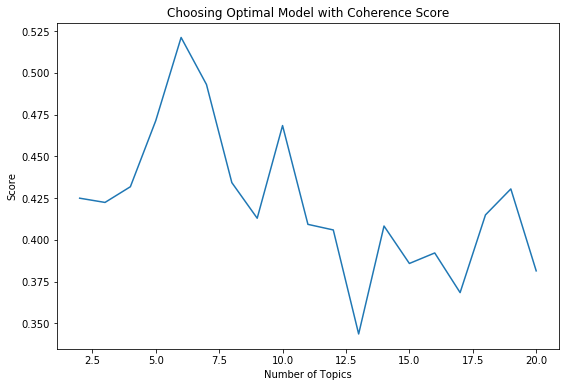

In [12]:
# Plot the coherence score for each number of topics
plt.figure(figsize=(9,6))
plt.plot(num_topic, coherence)
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.title('Choosing Optimal Model with Coherence Score');

In [13]:
# Get the best lda model with the ghiest coherence score
best_lda = model[coherence.index(max(coherence))]
print('Best number of topic:', best_lda.num_topics)
print('Best coherence score:', max(coherence))

Best number of topic: 6
Best coherence score: 0.5212264073764619


## Get Topic Keywords

In [14]:
# Show the components of each topic
best_lda.show_topics(num_words=20)

[(0,
  '0.017*"coffee" + 0.010*"cream" + 0.010*"donut" + 0.010*"gluten" + 0.010*"breakfast" + 0.009*"ice" + 0.008*"pancake" + 0.008*"gluten_free" + 0.008*"ice_cream" + 0.008*"chocolate" + 0.007*"free" + 0.006*"crepe" + 0.006*"cookie" + 0.005*"smoothie" + 0.005*"toast" + 0.005*"vegan" + 0.004*"latte" + 0.004*"shop" + 0.004*"french" + 0.004*"pastry"'),
 (1,
  '0.005*"great" + 0.004*"good" + 0.004*"place" + 0.004*"pizza" + 0.004*"love" + 0.003*"beer" + 0.003*"food" + 0.003*"try" + 0.003*"nice" + 0.003*"menu" + 0.003*"bar" + 0.003*"amazing" + 0.003*"delicious" + 0.003*"salad" + 0.003*"service" + 0.003*"happy" + 0.003*"drink" + 0.003*"friendly" + 0.003*"atmosphere" + 0.003*"come"'),
 (2,
  '0.010*"great" + 0.008*"love" + 0.008*"food" + 0.008*"good" + 0.008*"place" + 0.007*"service" + 0.007*"friendly" + 0.007*"amazing" + 0.006*"delicious" + 0.006*"staff" + 0.006*"price" + 0.006*"recommend" + 0.005*"definitely" + 0.005*"chicken" + 0.005*"fresh" + 0.005*"try" + 0.005*"lunch" + 0.005*"favorite"

In [15]:
# Add topic label manually
topic_label = ['Coffee/Dessert', 
               'Food/Atmosphere', 
               'Food/Service', 
               'Wait Time',
               'Mexican Food',
               'Breakfast']
topic_dict = {i:topic_label[i] for i in range(best_lda.num_topics)}

## Get Dominant Topic

In [16]:
def find_dominant_topic(x):
    topic_percent = [j for i, j in x]
    return topic_percent.index(max(topic_percent))

In [17]:
# Compute the dominant topic for each review
dominant_topic = pd.get_dummies([find_dominant_topic(x) for x in best_lda[tfidf_corpus]]).rename(columns=topic_dict)
dominant_topic.head()

,Coffee/Dessert,Food/Atmosphere,Food/Service,Wait Time,Mexican Food,Breakfast
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [18]:
review_df = review_df.merge(dominant_topic, left_index=True, right_index=True)
review_df.shape

(781473, 14)

In [19]:
review_df.head()

,business_id,cool,date,funny,stars,useful,review_length,clean_text,Coffee/Dessert,Food/Atmosphere,Food/Service,Wait Time,Mexican Food,Breakfast
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,1,3,81,chevo chandler delicious ahwatukee different r...,0,1,0,0,0,0
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,1,6,21,place dirty grimy twice service horrible,0,0,0,1,0,0
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,4,0,25,holy portion size lot bang buck service super ...,0,0,1,0,0,0
3,iIjVO7cLD1UEmIO7G05Ujw,0,2016-06-11,0,4,0,60,flavor actually pretty good eat menudo tortill...,0,0,0,1,0,0
4,1JF9TbJ2d5hH8xsQvvklHg,0,2016-06-18,0,5,1,94,place great flavor thing ask bring chip salsa ...,0,0,0,1,0,0


## Sentiment Score

In [20]:
# Compute sentiment score
review_df['polarity'] = review_df['clean_text'].apply(lambda sent: TextBlob(str(sent)).sentiment.polarity)
review_df['subjectivity'] = review_df['clean_text'].apply(lambda sent: TextBlob(str(sent)).sentiment.subjectivity)

## Review Count

In [21]:
# Caclulate the number of reviews in the dataset
review_count = review_df.groupby('business_id').count().iloc[:,0].to_dict()

## Restaurant Age

In [22]:
# Convert string date to datetime format
review_df['date'] = review_df['date'].apply(lambda x: pd.to_datetime(x))

In [23]:
# Create dictionary of estimated restaurant age
restaurant_age = review_df[['business_id', 'date']].groupby('business_id') \
                                                    .agg(lambda x: pd.datetime(2017, 12, 31) - min(x))['date'] \
                                                    .apply(lambda x: x.days / 365) \
                                                    .to_dict()

## Combine Review Features

In [24]:
# Take the mean of numeric features group by business id
review_df = review_df.groupby('business_id').mean().reset_index()

## Aggregate Features

In [25]:
# Create aggregate variables
review_df['restaurant_age'] = review_df['business_id'].apply(lambda row: restaurant_age[row])
review_df['review_count'] = review_df['business_id'].apply(lambda row: restaurant_age[row])
review_df.shape

(7183, 16)

In [26]:
# View the first few lines of data 
review_df.head()

,business_id,cool,funny,stars,useful,review_length,Coffee/Dessert,Food/Atmosphere,Food/Service,Wait Time,Mexican Food,Breakfast,polarity,subjectivity,restaurant_age,review_count
0,-01XupAWZEXbdNbxNg5mEg,0.818182,0.714286,2.857143,1.610390,120.259740,0.00000,0.428571,0.064935,0.480519,0.00000,0.025974,0.184144,0.613380,8.257534,8.257534
1,-092wE7j5HZOogMLAh40zA,0.265060,0.216867,3.349398,1.397590,106.867470,0.00000,0.048193,0.566265,0.337349,0.00000,0.048193,0.149639,0.606846,8.386301,8.386301
2,-0Sgh0QlUKVsWosCWJzGqQ,0.136364,0.477273,1.977273,0.704545,90.340909,0.00000,0.045455,0.045455,0.909091,0.00000,0.000000,0.009063,0.554916,7.326027,7.326027
3,-0WegMt6Cy966qlDKhu6jA,0.376623,0.246753,2.142857,0.662338,124.688312,0.00000,0.259740,0.012987,0.727273,0.00000,0.000000,-0.022920,0.545097,4.712329,4.712329
4,-0aIra_B6iALlfqAriBSYA,0.562500,0.375000,4.625000,0.937500,75.406250,0.03125,0.500000,0.125000,0.281250,0.03125,0.031250,0.324154,0.589466,2.531507,2.531507


In [27]:
review_df.to_csv('final_review.csv', index=False)